# Dependencies 

In [1]:
import numpy as np

from functools import cache
from dataset import Dataset

from typing import Sequence

# Overview
Below you will find two methods of interpolating measurements from one set of locations to another set of locations via a mean weighted by the inverse distance squared.

## 1. Procedural interpolation 
The method of interpolation without using a class is arguably more flexible and is faster for scenarios where the set of coordinates onto which the measurements are interpolated changes frequently. It benefits from vectorised computation and broadcasting; however, when interpolating onto very large sets of nodes (~100k nodes) it may suffer from insufficient memory; in which case interpolation using the Interpolator class might be preferrable. 

In [2]:
def dists(x: np.array, y: np.array, /) -> np.array:
    """
    Compute distances between each element of x and each element of y. 
    x: (n, k) array 
    y: (m, k) array
    return: (n, m) array of distances 
    """
    return np.linalg.norm(y - x.reshape(-1, 1, 2), axis=2)


def weights(x: np.array, y: np.array, /) -> np.array: 
    """
    Compute weights (inverse distances squared) between each element of x and each element of y.
    """
    return np.power(dists(x, y), -2)


def interpolate(to: np.array, fro: np.array, val: np.array) -> np.array:
    """
    Interpolate values from positions in fro to positions in to accoring to the average weighted by 
    the inverse distances squared. 
    """
    return np.average(
        np.broadcast_to(val, (len(to), len(val))), 
        axis=1, 
        weights=weights(to, fro),
    )

## 2. Interpolation with the Interpolator class
The interpolator class works on the assumption that the coordinates onto which the measurements are interpolated do not change. This enables the use of caching which yields about a tenfold runtime improvement over the procedural method, if the coordinates with measurements do not change often e.g. the coordinates of CPCB stations are essentially static. The Interpolator class can still be used to interpolate onto variable coordinates by instantiating a new Interpolator object for each set of new coordinates; however, if such a need arises often, one should consider the previous method. 

In [3]:
class Interpolator:
    """
    Interpolates measurements from a variable set of coordinates to a static set of coordinates. The 
    Intepolator class utilises caching to greatly improve the runtime where the set of coordinates, 
    from which the measurements are interpolated, does not change often.
    """

    def __init__(self, to: np.array):
        """
        to: the static set of coordinates onto which the measurements will be interpolated. 
        """
        self.to = to

    @cache
    def dist(self, fro: tuple) -> np.array:
        """
        Cached euclidean distance function. The fro argument must be a immutable in order to be cachable. 
        """
        return np.linalg.norm(self.to - fro, axis=1)

    def dists(self, fros: np.array) -> np.array:
        """
        Euclidean distance for entire array of coordinates. These are internally converted into tuples, 
        so the argument need not be immutable, as opposed to the dist method. 
        """
        return np.fromiter((
            self.dist(tuple(fro)) for fro in fros
        ), dtype=np.dtype((float, len(self.to)))).T 

    def weights(self, fros: np.array) -> np.array:
        """
        Compute weights (inverse distances squared) between each element of fros and each element of 
        self.to. Whenever a zero-distance position is enountered, it is given a weight of 1 and all 
        non-zero distance positions are given a weight of 0. 
        """
        dist = self.dists(fros=fros)
        return np.fromiter((
            zeros if np.any(zeros := row == 0) else np.power(row, -2)
            for row in dist
        ), dtype=np.dtype((float, (len(fros), ))))

    def interpolate(self, fros: np.array, vals: np.array) -> np.array:
        """
        Interpolate a snapshot. TODO perhaps change the arguments to a single snapshot object. 
        """
        return np.average(
            np.broadcast_to(vals, (len(self.to), len(vals))),
            axis=1,
            weights=self.weights(fros=fros)
        )

    def interpolate_batch(self, pm_batch: Sequence[np.array], gps_batch: Sequence[np.array]) -> np.array:
        """
        Convenience function for interpolating an entire batch. 
        """
        return np.fromiter((
            self.interpolate(fros=gps, vals=pm) for pm, gps in zip(pm_batch, gps_batch)
        ), dtype=np.dtype((float, len(self.to))))

    def clear_cache(self) -> None:
        """
        When the positions from which the values are interpolated vary frequently, the cache might get 
        prohibitively large and one might want to clear it. Another solutions for cache management would
        be to change the cache decorator to lru_cache. 
        """
        self.dist.cache_clear()

    def __call__(self, *args, **kwargs) -> np.array:
        return self.interpolate(*args, **kwargs)

# Example 
We will be interpolating measurements at CPCB stations to a large graph of New Delhi encompassing all of the stations. 

In [5]:
import pandas as pd 
import osmnx as ox

from matplotlib import pyplot as plt
from osmnx_utils import extract_positions

In [6]:
pm_gps = pd.read_csv('../TF/data/DAP_CPCB_all', 
                index_col='timestamp', 
                parse_dates=['timestamp'],)
dataset = Dataset(pm_gps=pm_gps, snapshot_minutes=15)

# with these settings, the last batch will contain the CPCB stations 
batch = dataset[-1]
SNAPSHOT_NO = 3000
snapshot = batch[SNAPSHOT_NO]

The graph encompassing all of the CPCB stations is very large; thus, it takes a long time to download and a long time to plot using the ox.plot_graph function. To reduce running time, you can decrease the dist parameter or plot the graph using plt.scatter.

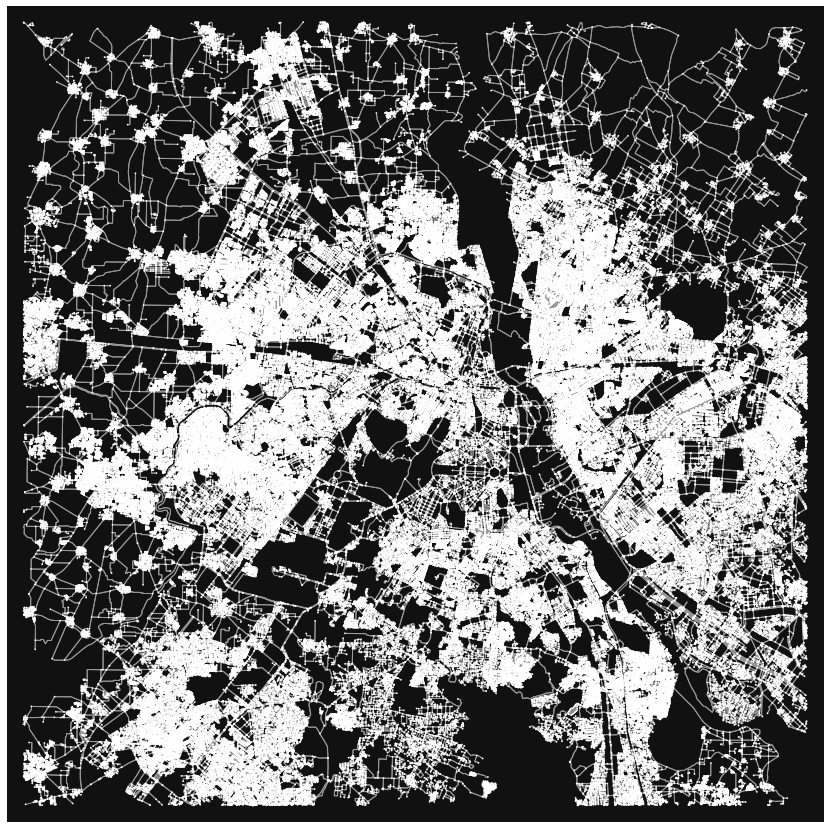

In [7]:
G = ox.graph_from_point(snapshot.gps.mean(axis=0)[::-1], dist=25000, network_type='drive', simplify=True)
G_gps = extract_positions(G=G)
fig, ax = ox.plot_graph(G=G, node_size=3, figsize=(15, 15))

In [8]:
# Procedural interpolation 
interpolated_procedurally = interpolate(to=G_gps, fro=snapshot.gps, val=snapshot.pm)

# Interpolation using Interpolator
interpolator = Interpolator(to=G_gps)
interpolated_with_interpolator = interpolator(fros=snapshot.gps, vals=snapshot.pm)

# Interpolating entire batch still takes a long time, as the batch extends over ~year-long period of time
# Thus, we limit its length for demonstration 
BATCH_LENGTH=4
batch_interpolated = interpolator.interpolate_batch(
    pm_batch=batch.pm[SNAPSHOT_NO:SNAPSHOT_NO+BATCH_LENGTH], 
    gps_batch=batch.gps[SNAPSHOT_NO:SNAPSHOT_NO+BATCH_LENGTH])

In the plots below, the points where measurements were taken are circled in red.

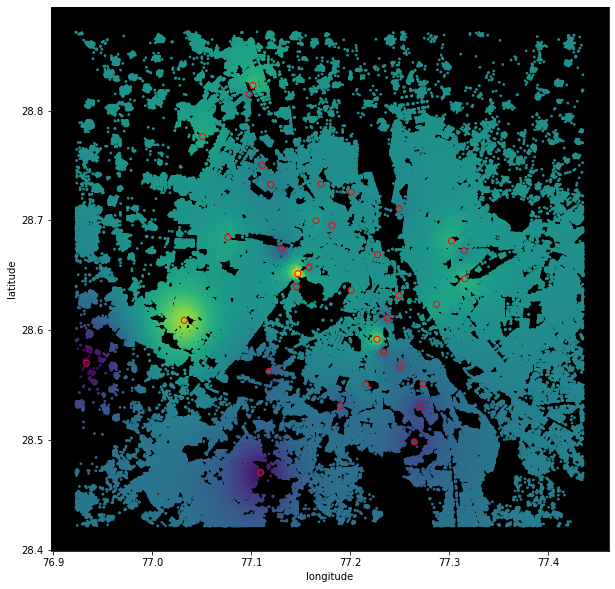

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(*G_gps.T, s=3, c=interpolated_procedurally)
ax.scatter(*snapshot.gps.T, c=snapshot.pm.T, edgecolors='red')
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_facecolor('black')

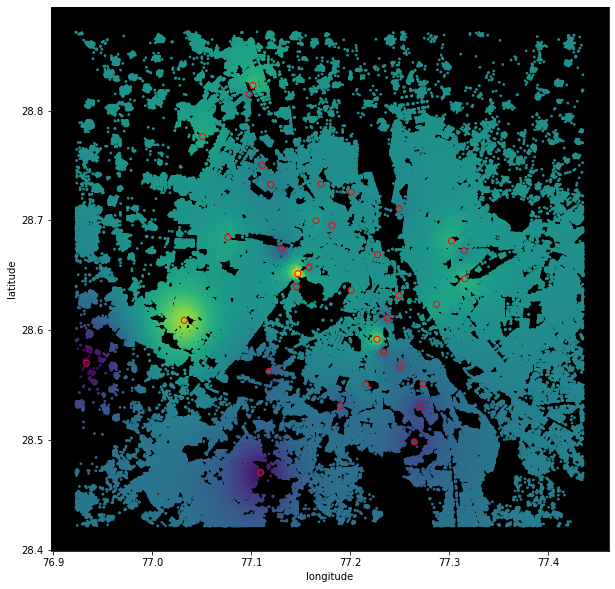

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(*G_gps.T, s=3, c=interpolated_with_interpolator)
ax.scatter(*snapshot.gps.T, c=snapshot.pm.T, edgecolors='red')
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
ax.set_facecolor('black')

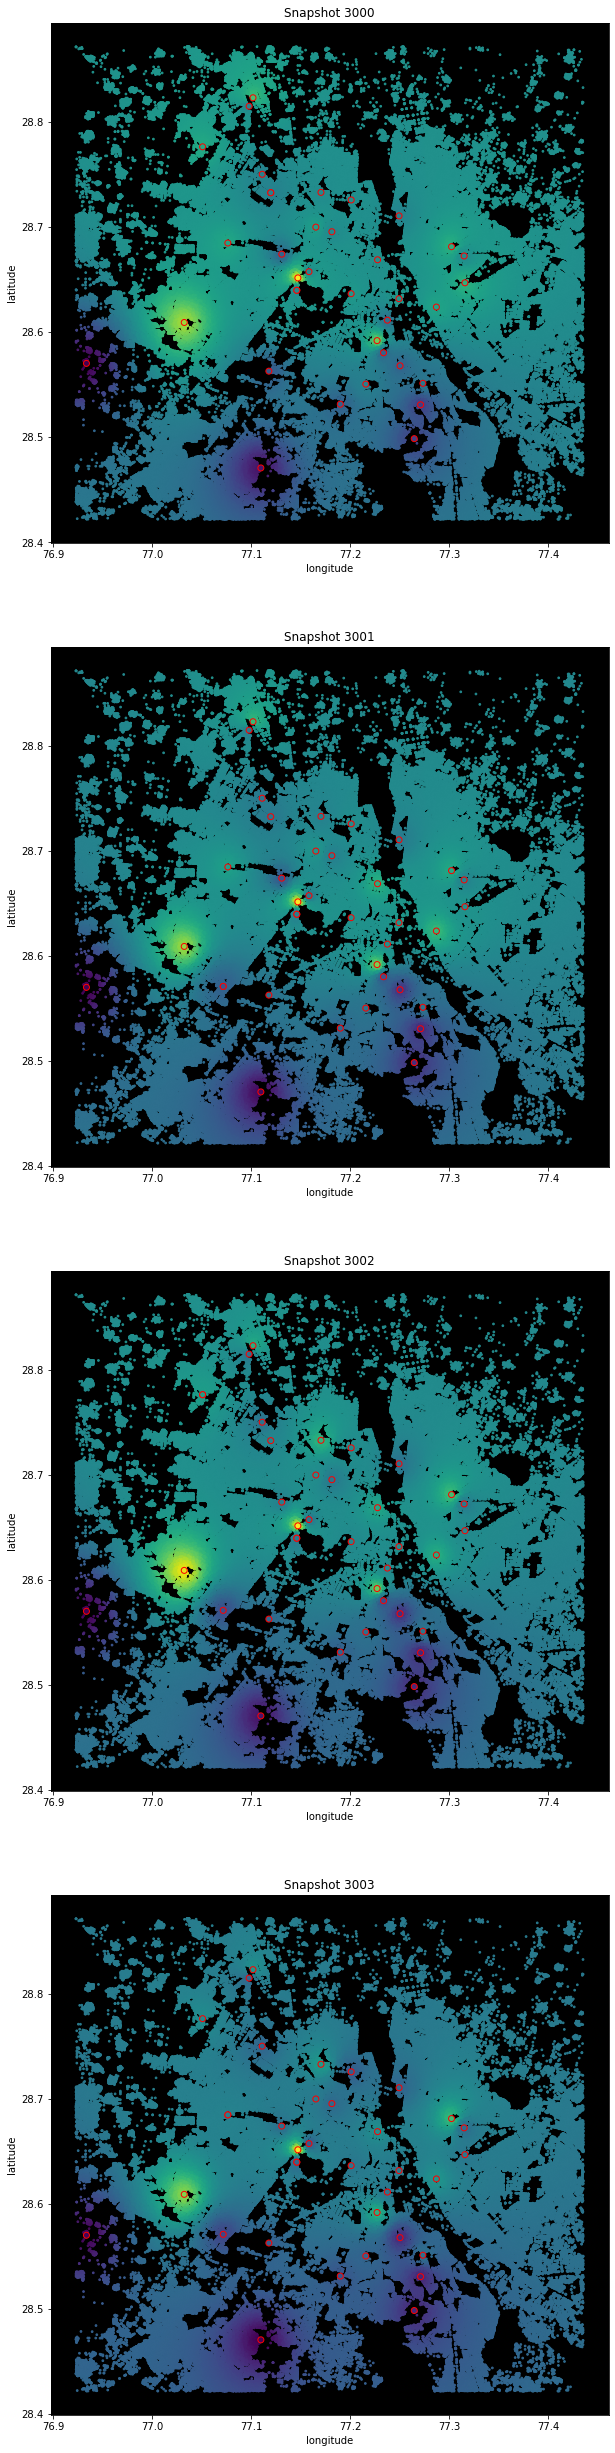

In [11]:
fig, axes = plt.subplots(BATCH_LENGTH, 1, figsize=(10, 11*BATCH_LENGTH))
for k, (ax, snapshot_interpolated, snapshot) in enumerate(
    zip(axes, batch_interpolated, batch[SNAPSHOT_NO:SNAPSHOT_NO+BATCH_LENGTH])): 
    ax.scatter(*G_gps.T, s=3, c=snapshot_interpolated)
    ax.scatter(*snapshot.gps.T, c=snapshot.pm.T, edgecolors='red')
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    ax.set_facecolor('black')  
    ax.set_title(f'Snapshot {SNAPSHOT_NO + k}')